In [1]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import pandas as pd
from Bio.Seq import Seq
from typing import List, Dict, Union



def open_gff3_files(path:str= '') -> List[List[str]]:
    '''
    Opens and reads a GFF3 file and returns its contents as a list of lists.

    Parameters:
    -----------
    path: str
        The path to the GFF3 file.

    Returns:
    --------
    List[List[str]]
        A list of lists containing the contents of the GFF3 file.
    '''
    with open(path, 'r') as infile:
        LINES = []
        for line in infile:
            LINES.append(line[:].split('\t'))
        LINES = LINES[1:]
    
    return LINES



def tidy_up_gff(lst_of_gff:list) -> list:
    """
    This function takes a list of GFF lines and returns a list of dictionaries,
    with each dictionary containing information on the signal peptides in the GFF file.
    
    Parameters:
    lst_of_gff (list): A list of GFF lines.
    
    Returns:
    list_of_peptides (list): A list of dictionaries, with each dictionary containing information on the signal peptides in the GFF file.
    """
    signal_peptides = {}
    list_of_peptides = []

    for peptide in lst_of_gff:
        signal_peptides['gene'] = peptide[0][:19]
        signal_peptides['start_pos'] = int(peptide[3])-1
        signal_peptides['end_pos']= int(peptide[4])+1 # We want to get the last AA downstream from the cleavage
        signal_peptides['signal_peptide_likelyhood']= peptide[5]
        list_of_peptides.append(signal_peptides)
        signal_peptides = {'gene':'', 'start_pos':'', 'end_pos':'','signal_peptide_likelyhood': '' }

    return list_of_peptides




def dict_of_signal_peptides(path: str = '') -> List[Dict[str, Union[str, int]]]:
    """
    Given a path to a GFF3 file, returns a list of dictionaries with information on signal peptides.

    Args:
        path (str): Path to the GFF3 file. Default is an empty string.

    Returns:
        list: A list of dictionaries where each dictionary contains the following keys:
            - 'gene' (str): Gene name of the signal peptide.
            - 'start_pos' (int): Start position of the signal peptide in the protein sequence.
            - 'end_pos' (int): End position of the signal peptide in the protein sequence.
            - 'signal_peptide_likelyhood' (str): The likelihood of the sequence being a signal peptide.
    """
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)
    return dict_of_signal_peptides


def read_gff_to_pd(path:str= '') -> pd.DataFrame:
    """
    Reads a GFF3 file and returns a pandas DataFrame with columns 'gene', 'start_pos', 'end_pos', 
    and 'signal_peptide_likelyhood'.
    
    Parameters:
    -----------
    path : str
        The path to the GFF3 file.
        
    Returns:
    --------
    df : pandas.DataFrame
        A DataFrame with columns 'gene', 'start_pos', 'end_pos', and 'signal_peptide_likelyhood'.
    """
    
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)
    df = pd.DataFrame.from_records(dict_of_signal_peptides)
    
    return df



def get_signal_peptides_cross_ref_with_genome(list_of_peptides: List[dict], all_proteins: List[SeqRecord]) -> List[SeqRecord]:
    """
    Extracts the protein sequence that corresponds to each predicted signal peptide sequence from the input list
    of peptides and matches the signal peptide to its corresponding protein sequence in the input list of 
    protein sequences.
    
    Parameters
    ----------
    list_of_peptides : list
        A list of dictionaries containing information about predicted signal peptide sequences, including gene name, 
        start and end positions, and the signal peptide likelihood score.
    all_proteins : list
        A list of SeqRecord objects containing protein sequences.
    
    Returns
    -------
    list
        A list of SeqRecord objects that correspond to the input predicted signal peptide sequences, including 
        protein sequence, ID, name, and a description indicating that the sequence corresponds to a predicted 
        signal peptide.
    """
    signal_peptide_seqs = []

    for signal_peptide in list_of_peptides:
        for seqrecord in all_proteins:
            if signal_peptide['gene'] in seqrecord.id:             
                seq = SeqRecord(
                    Seq(seqrecord.seq[signal_peptide['start_pos']:signal_peptide['end_pos']]), 
                    id=seqrecord.id,
                    name=seqrecord.name,
                    description="signal_peptide predicted by signalP")

                signal_peptide_seqs.append(seq)

    return signal_peptide_seqs


def add_dunder_tail(peptide:str , max_lenght:int=22 ): 
    '''Adds a tail if a peptide is shorter than the specified max_len.
    '''
    if len(peptide) < max_lenght: 
        difference = max_lenght - len(peptide)
        sequence = peptide + ('-'*difference)
    else: 
        sequence = peptide
        
    return sequence     


# 01_SignalP_analysis

## Introduction
The objective of this project is to analyze the signal peptides of the A.oryzae genome. The first step is to download the genome and partition it into 5000 bits. These bits will then be uploaded to SignalP, a tool for predicting signal peptides. The program will retrieve the signal peptides from SignalP and perform an analysis of different regions. Finally, the project will create position weight matrices (PWM) for all peptides, median peptides, and peptides found from proteomics data.

### Objective: 


- Download the A.oryzae genome
- Partition the genome into 5000 bits
- Upload the partitioned genome to SignalP
- Retrieve signal peptides from the SignalP analysis
- Analyze different regions of the signal peptides
- Create position weight matrices (PWM) for all peptides, median peptides, and peptides found from proteomics data.

In [2]:
from teemi.design.fetch_sequences import read_fasta_files

In [3]:
proteins = read_fasta_files('../data/00_A_oryzae_genome_and_partitions/a_oryze_genome_and_partitions/FungiDB-59_AoryzaeRIB40_AnnotatedProteins.fasta')
len(proteins)

12090

### Partitioning the proteins into 5000 long fasta files

In [4]:
partition1 = proteins[0:5000]
partition2 = proteins[5000:10000]
partition3 = proteins[10000:]

print(f'The length of partition 1 : {len(partition1)}')
print(f'The length of partition 2 : {len(partition2)}')
print(f'The length of partition 3 : {len(partition3)}')

The length of partition 1 : 5000
The length of partition 2 : 5000
The length of partition 3 : 2090


In [5]:
all_partitions = [[partition1]+[partition2]+[partition3]]
all_partitions = [partition1+partition2+partition3]

len(all_partitions)

1

In [6]:
# Write the files
write = False

if write: 
    with open(f"/Users/lucaslevassor/projects/Signal_peptide_project/data/00_A_oryzae_genome_and_partitions/a_oryze_genome_and_partitions/partition1.fasta", "w") as output_handle:
        SeqIO.write(partition1, output_handle, "fasta")
    with open(f"/Users/lucaslevassor/projects/Signal_peptide_project/data/00_A_oryzae_genome_and_partitions/a_oryze_genome_and_partitions/partition2.fasta", "w") as output_handle:
        SeqIO.write(partition2, output_handle, "fasta")
    with open(f"/Users/lucaslevassor/projects/Signal_peptide_project/data/00_A_oryzae_genome_and_partitions/a_oryze_genome_and_partitions/partition3.fasta", "w") as output_handle:
        SeqIO.write(partition3, output_handle, "fasta")

These partitions have been sent to SignalP and run on their servers. 

### Examining SignalP output


In signalP with the following parameters were used: 

Organism : Eukarya
Output format: Short output (no figures)
Model mode: Slow
 


Output from SignalP are shown below : gff files are just a text file. So we can parse it like a normal text file:

In [7]:
partition1_signal_peptides = read_gff_to_pd('../data/01_SignalP_output/Partition1/output.gff3')
partition2_signal_peptides = read_gff_to_pd('../data/01_SignalP_output/Partition2 /output (1).gff3')
partition3_signal_peptides = read_gff_to_pd('../data/01_SignalP_output/Partition3/output (2).gff3')

all_signal_peptides_df = pd.concat([partition1_signal_peptides, partition2_signal_peptides, partition3_signal_peptides])
all_signal_peptides_df

,gene,start_pos,end_pos,signal_peptide_likelyhood
0,AO090005000016-T-p1,0,25,0.99980325
1,AO090005000029-T-p1,0,25,0.99983543
2,AO090005000042-T-p1,0,25,0.99984324
3,AO090005000053-T-p1,0,43,0.8548089
4,AO090005000059-T-p1,0,20,0.9998212
...,...,...,...,...
196,AO090103000483-T-p1,0,21,0.83310604
197,AO090103000487-T-p1,0,21,0.99971014
198,AO090103000493-T-p1,0,19,0.99979144
199,AO090701000994-T-p1,0,20,0.99984515


We got 1061 signal peptides predicted from the A.oryzae genome. Let's add them together make them into a list of dicts.

In [8]:
partition1_signal_peptides = dict_of_signal_peptides('../data/01_SignalP_output/Partition1/output.gff3')
partition2_signal_peptides = dict_of_signal_peptides('../data/01_SignalP_output/Partition2 /output (1).gff3')
partition3_signal_peptides = dict_of_signal_peptides('../data/01_SignalP_output/Partition3/output (2).gff3')
all_signal_peptides = partition1_signal_peptides +partition2_signal_peptides+ partition3_signal_peptides

In [9]:
all_signal_peptides[:5]

[{'gene': 'AO090005000016-T-p1',
  'start_pos': 0,
  'end_pos': 25,
  'signal_peptide_likelyhood': '0.99980325'},
 {'gene': 'AO090005000029-T-p1',
  'start_pos': 0,
  'end_pos': 25,
  'signal_peptide_likelyhood': '0.99983543'},
 {'gene': 'AO090005000042-T-p1',
  'start_pos': 0,
  'end_pos': 25,
  'signal_peptide_likelyhood': '0.99984324'},
 {'gene': 'AO090005000053-T-p1',
  'start_pos': 0,
  'end_pos': 43,
  'signal_peptide_likelyhood': '0.8548089'},
 {'gene': 'AO090005000059-T-p1',
  'start_pos': 0,
  'end_pos': 20,
  'signal_peptide_likelyhood': '0.9998212'}]

### Cross reference with the genome to extract the signal peptides

The function below goes through the genome and if it finds a genome annotation that fits with the signal peptides we got from signalP it takes the sequence and saves it as Seqrecord objects: 
    

In [10]:
pure_signal_peptide = get_signal_peptides_cross_ref_with_genome(all_signal_peptides, proteins)
print(pure_signal_peptide[0])
print(len(pure_signal_peptide[0]))

ID: AO090005000016-T-p1
Name: AO090005000016-T-p1
Description: signal_peptide predicted by signalP
Number of features: 0
Seq('MAPSHSFMLFLSVICTHLCSLVVAV')
25


In [11]:
pure_signal_peptide[0].format('fasta')

'>AO090005000016-T-p1 signal_peptide predicted by signalP\nMAPSHSFMLFLSVICTHLCSLVVAV\n'

We can add the sequences to the dataframe like such: 

In [12]:
all_signal_peptides_df['sequence'] =[str(signal_peptide.seq) for signal_peptide in pure_signal_peptide]
all_signal_peptides_df.to_clipboard()

Lets write all the motifs to a FASTA file:

In [13]:
with open('../data/02_all_signal_peptides/SPs_predicted_by_SignalP_A_oryze_RIB40.fasta', 'w') as outhandle: 
    for i in range(len(pure_signal_peptide)): 
        outhandle.write(pure_signal_peptide[i].format('fasta'))

### Statistics of the signal peptides

In [14]:
### Statistics on lenght: 
mean_length = all_signal_peptides_df["end_pos"].mean()
mean_length 


23.388312912346844

In [15]:
### Statistics on lenght: 
median = all_signal_peptides_df["end_pos"].median()
median 

22.0

In [16]:
### Statistics on lenght: 
describe = all_signal_peptides_df["end_pos"].describe()
describe 

count    1061.000000
mean       23.388313
std         6.170687
min        14.000000
25%        20.000000
50%        22.000000
75%        26.000000
max        70.000000
Name: end_pos, dtype: float64

Lets get the differenct regions of the signal peptides: 

##  Regions of Signal peptides

In [17]:
partition1_signal_peptides_regions = read_gff_to_pd('../data/01_SignalP_output/Partition1/region_output.gff3')
partition2_signal_peptides_regions = read_gff_to_pd('../data/01_SignalP_output/Partition2 /region_output (1).gff3')
partition3_signal_peptides_regions = read_gff_to_pd('../data/01_SignalP_output/Partition3/region_output (2).gff3')

In [18]:
all_signal_peptide_regions = pd.concat([partition1_signal_peptides_regions,partition2_signal_peptides_regions,partition3_signal_peptides_regions])
all_signal_peptide_regions.columns = ['gene',	'start_pos_region','end_pos_region','region']
all_signal_peptide_regions

,gene,start_pos_region,end_pos_region,region
0,AO090005000016-T-p1,0,5,.
1,AO090005000016-T-p1,4,22,.
2,AO090005000016-T-p1,21,25,.
3,AO090005000029-T-p1,0,3,.
4,AO090005000029-T-p1,2,14,.
...,...,...,...,...
598,AO090701000994-T-p1,2,14,.
599,AO090701000994-T-p1,13,20,.
600,AO090701001287-T-p1,0,4,.
601,AO090701001287-T-p1,3,19,.


In [19]:
# every region is the same N, H, C. will just append a long list 
regions = ['n-region', 'h-region', 'c-region']* int((len(all_signal_peptide_regions)/3))
all_signal_peptide_regions['region'] = regions

In [20]:
merged = pd.merge(all_signal_peptides_df,all_signal_peptide_regions , on=["gene"])


# Define the column you want to update
target_column = 'start_pos_region'

# Add 2 to non-zero cells in the target column - BECAUSE this function was meant to only add the last aa from the SignalP output for the pure signal peptides
merged.loc[merged[target_column] != 0, target_column] += 1


# Define the column you want to update
target_column = 'end_pos_region'

# Add 2 to non-zero cells in the target column - BECAUSE this function was meant to only add the last aa from the SignalP output for the pure signal peptides
merged.loc[merged[target_column] != 0, target_column] += -1


# We can get relative lenght like this: 
merged['relative_length'] = merged['end_pos_region'] - merged['start_pos_region']


merged

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,relative_length
0,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,0,4,n-region,4
1,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,5,21,h-region,16
2,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,22,24,c-region,2
3,AO090005000029-T-p1,0,25,0.99983543,MHLRNIVIALAATAVASPVDLQDRQ,0,2,n-region,2
4,AO090005000029-T-p1,0,25,0.99983543,MHLRNIVIALAATAVASPVDLQDRQ,3,13,h-region,10
...,...,...,...,...,...,...,...,...,...
3178,AO090701000994-T-p1,0,20,0.99984515,MRLLLIAPLFSAVSYGAQAT,3,13,h-region,10
3179,AO090701000994-T-p1,0,20,0.99984515,MRLLLIAPLFSAVSYGAQAT,14,19,c-region,5
3180,AO090701001287-T-p1,0,23,0.99986553,MLFYRAFGGLLCFLYACVTVSAF,0,3,n-region,3
3181,AO090701001287-T-p1,0,23,0.99986553,MLFYRAFGGLLCFLYACVTVSAF,4,18,h-region,14


Lets get the sequences from the dataframe above. Make sure that that we start from the correct position. 

In [21]:
# initite empty column
merged['region_seq'] = ''

In [22]:
# initite empty column
merged['region_seq'] = ''

list_of_seqs = []
for index, row in merged.iterrows():
    if row['start_pos_region'] == 0: 
        start = int(row['start_pos_region'])
        stop = int(row['end_pos_region'])
        list_of_seqs.append(row['sequence'][start:stop])
    else: 
        start = int(row['start_pos_region'])-1
        stop = int(row['end_pos_region'])
        list_of_seqs.append(row['sequence'][start:stop]) 
    
merged['region_seq'] = list_of_seqs

In [23]:
merged.head(10)

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,relative_length,region_seq
0,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,0,4,n-region,4,MAPS
1,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,5,21,h-region,16,HSFMLFLSVICTHLCSL
2,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,22,24,c-region,2,VVA
3,AO090005000029-T-p1,0,25,0.99983543,MHLRNIVIALAATAVASPVDLQDRQ,0,2,n-region,2,MH
4,AO090005000029-T-p1,0,25,0.99983543,MHLRNIVIALAATAVASPVDLQDRQ,3,13,h-region,10,LRNIVIALAAT
5,AO090005000029-T-p1,0,25,0.99983543,MHLRNIVIALAATAVASPVDLQDRQ,14,24,c-region,10,AVASPVDLQDR
6,AO090005000042-T-p1,0,25,0.99984324,MKASFISRLLSLTAFAISSNLSYGL,0,2,n-region,2,MK
7,AO090005000042-T-p1,0,25,0.99984324,MKASFISRLLSLTAFAISSNLSYGL,3,21,h-region,18,ASFISRLLSLTAFAISSNL
8,AO090005000042-T-p1,0,25,0.99984324,MKASFISRLLSLTAFAISSNLSYGL,22,24,c-region,2,SYG
9,AO090005000053-T-p1,0,43,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVALSQ,0,26,n-region,26,MGLFLTALGALSSVNVLYSRGRMPLK


### Biochemical analysis

In [24]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

list_of_kyle_d = []
isoelectric_point =[]
charge = []

for index, row in merged.iterrows():
    protein = ProteinAnalysis(str(row['region_seq']))
    list_of_kyle_d.append(protein.gravy())
    charge.append(protein.charge_at_pH(7.6))

merged['kd_hydrophobicity'] = list_of_kyle_d
merged['charge_at_ph7'] = charge

In [25]:
merged

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,relative_length,region_seq,kd_hydrophobicity,charge_at_ph7
0,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,0,4,n-region,4,MAPS,0.325000,-0.799151
1,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,5,21,h-region,16,HSFMLFLSVICTHLCSL,1.582353,-0.586943
2,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,22,24,c-region,2,VVA,3.400000,-0.590986
3,AO090005000029-T-p1,0,25,0.99983543,MHLRNIVIALAATAVASPVDLQDRQ,0,2,n-region,2,MH,-0.650000,-0.775725
4,AO090005000029-T-p1,0,25,0.99983543,MHLRNIVIALAATAVASPVDLQDRQ,3,13,h-region,10,LRNIVIALAAT,1.590909,0.442738
...,...,...,...,...,...,...,...,...,...,...,...,...
3178,AO090701000994-T-p1,0,20,0.99984515,MRLLLIAPLFSAVSYGAQAT,3,13,h-region,10,LLLIAPLFSAV,2.536364,-0.557223
3179,AO090701000994-T-p1,0,20,0.99984515,MRLLLIAPLFSAVSYGAQAT,14,19,c-region,5,SYGAQA,-0.400000,-0.827738
3180,AO090701001287-T-p1,0,23,0.99986553,MLFYRAFGGLLCFLYACVTVSAF,0,3,n-region,3,MLF,2.833333,-0.799151
3181,AO090701001287-T-p1,0,23,0.99986553,MLFYRAFGGLLCFLYACVTVSAF,4,18,h-region,14,YRAFGGLLCFLYACV,1.460000,0.358234


#### Grouping the regions 

In [26]:
n_region = merged.groupby("region")
n_region = n_region.get_group('n-region')

h_region = merged.groupby("region")
h_region = h_region.get_group('h-region')

c_region = merged.groupby("region")
c_region = c_region.get_group('c-region')

In [27]:
c_region

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,relative_length,region_seq,kd_hydrophobicity,charge_at_ph7
2,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,22,24,c-region,2,VVA,3.400000,-0.590986
5,AO090005000029-T-p1,0,25,0.99983543,MHLRNIVIALAATAVASPVDLQDRQ,14,24,c-region,10,AVASPVDLQDR,-0.145455,-1.505143
8,AO090005000042-T-p1,0,25,0.99984324,MKASFISRLLSLTAFAISSNLSYGL,22,24,c-region,2,SYG,-0.833333,-0.827738
11,AO090005000053-T-p1,0,43,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVALSQ,37,42,c-region,5,PTVALS,1.116667,-0.147963
14,AO090005000059-T-p1,0,20,0.9998212,MHLQATLAVGLSLLGLTLAD,17,19,c-region,2,TLA,1.633333,-0.857574
...,...,...,...,...,...,...,...,...,...,...,...,...
3170,AO090103000483-T-p1,0,21,0.83310604,MKTSFLLAAIGFLYRLPCSAA,17,20,c-region,3,PCSA,0.475000,-0.186249
3173,AO090103000487-T-p1,0,21,0.99971014,MTRYLSFLFLLILFGNSVFTA,15,20,c-region,5,GNSVFT,0.266667,-0.557223
3176,AO090103000493-T-p1,0,19,0.99979144,MRGIVALSFLSVALGVTAD,15,18,c-region,3,GVTA,1.225000,-0.557223
3179,AO090701000994-T-p1,0,20,0.99984515,MRLLLIAPLFSAVSYGAQAT,14,19,c-region,5,SYGAQA,-0.400000,-0.827738


### Plotting hydrophicity per regions

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'c-region')

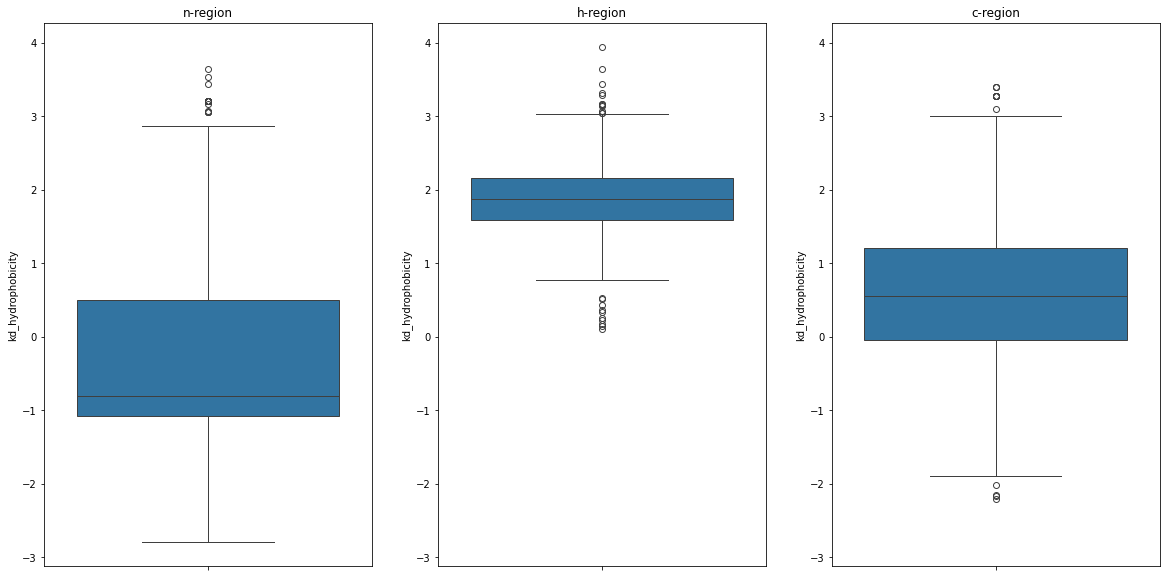

In [29]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(1,3,1)
ax1 = sns.boxplot(y=n_region["kd_hydrophobicity"], orient='vertical')


plt.title('n-region')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2 = sns.boxplot(y=h_region["kd_hydrophobicity"], orient='Vertical')

plt.title('h-region')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)

ax3 = sns.boxplot(y=c_region["kd_hydrophobicity"], orient='Vertical')
plt.title('c-region')



### Plotting charge_at_ph 7.6 per regions
The following article mentions that physiological ph is 7.6 for Aspergillus
ref : https://pubmed.ncbi.nlm.nih.gov/12135488/

Text(0.5, 1.0, 'c-region')

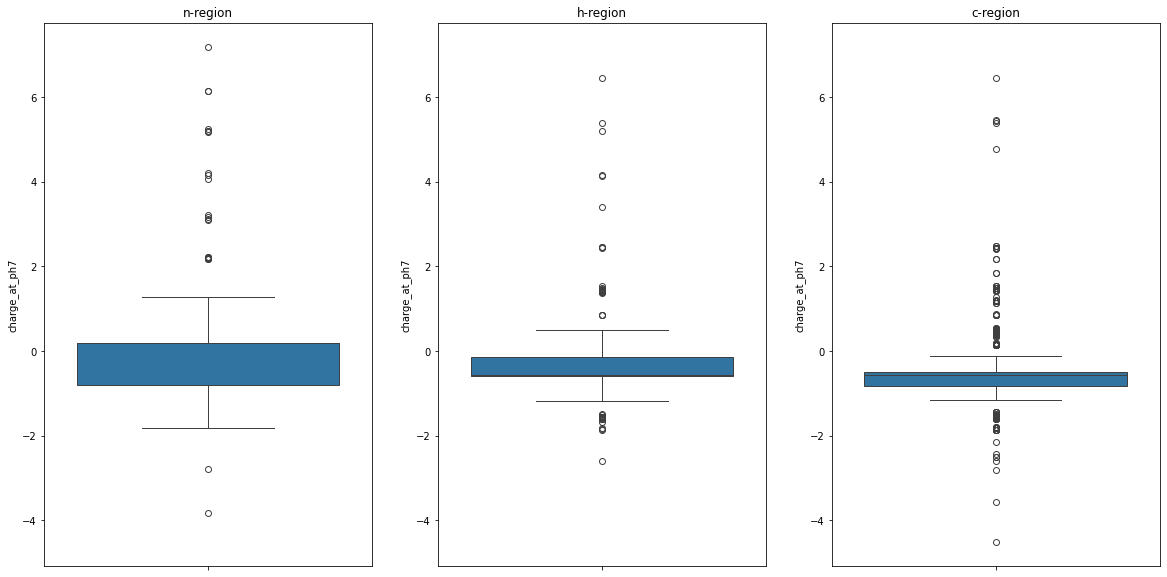

In [30]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,3,1, sharex=ax1, sharey=ax1)
ax1 = sns.boxplot(y=n_region["charge_at_ph7"], orient='vertical')

plt.title('n-region')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2 = sns.boxplot(y=h_region["charge_at_ph7"], orient='Vertical')

plt.title('h-region')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)

ax3 = sns.boxplot(y=c_region["charge_at_ph7"], orient='Vertical')
plt.title('c-region')

## Plotting the relative length of each region


Text(0.5, 1.0, 'c-region')

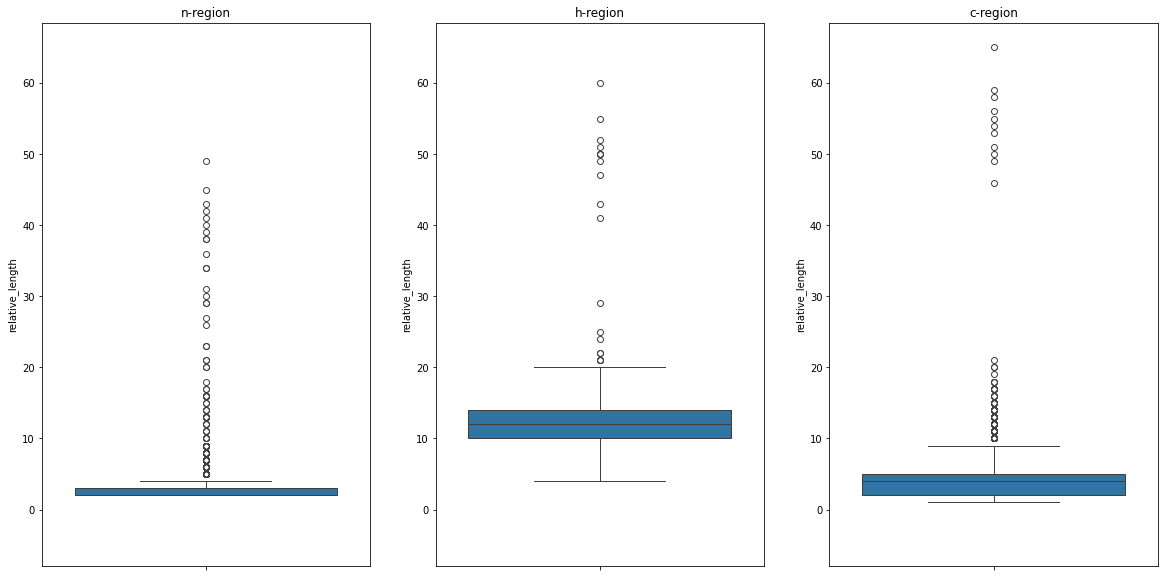

In [31]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,3,1, sharex=ax1, sharey=ax1)
ax1 = sns.boxplot(y=n_region["relative_length"], orient='vertical')

plt.title('n-region')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2 = sns.boxplot(y=h_region["relative_length"], orient='Vertical')

plt.title('h-region')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)

ax3 = sns.boxplot(y=c_region["relative_length"], orient='Vertical')
plt.title('c-region')

### Merged plots


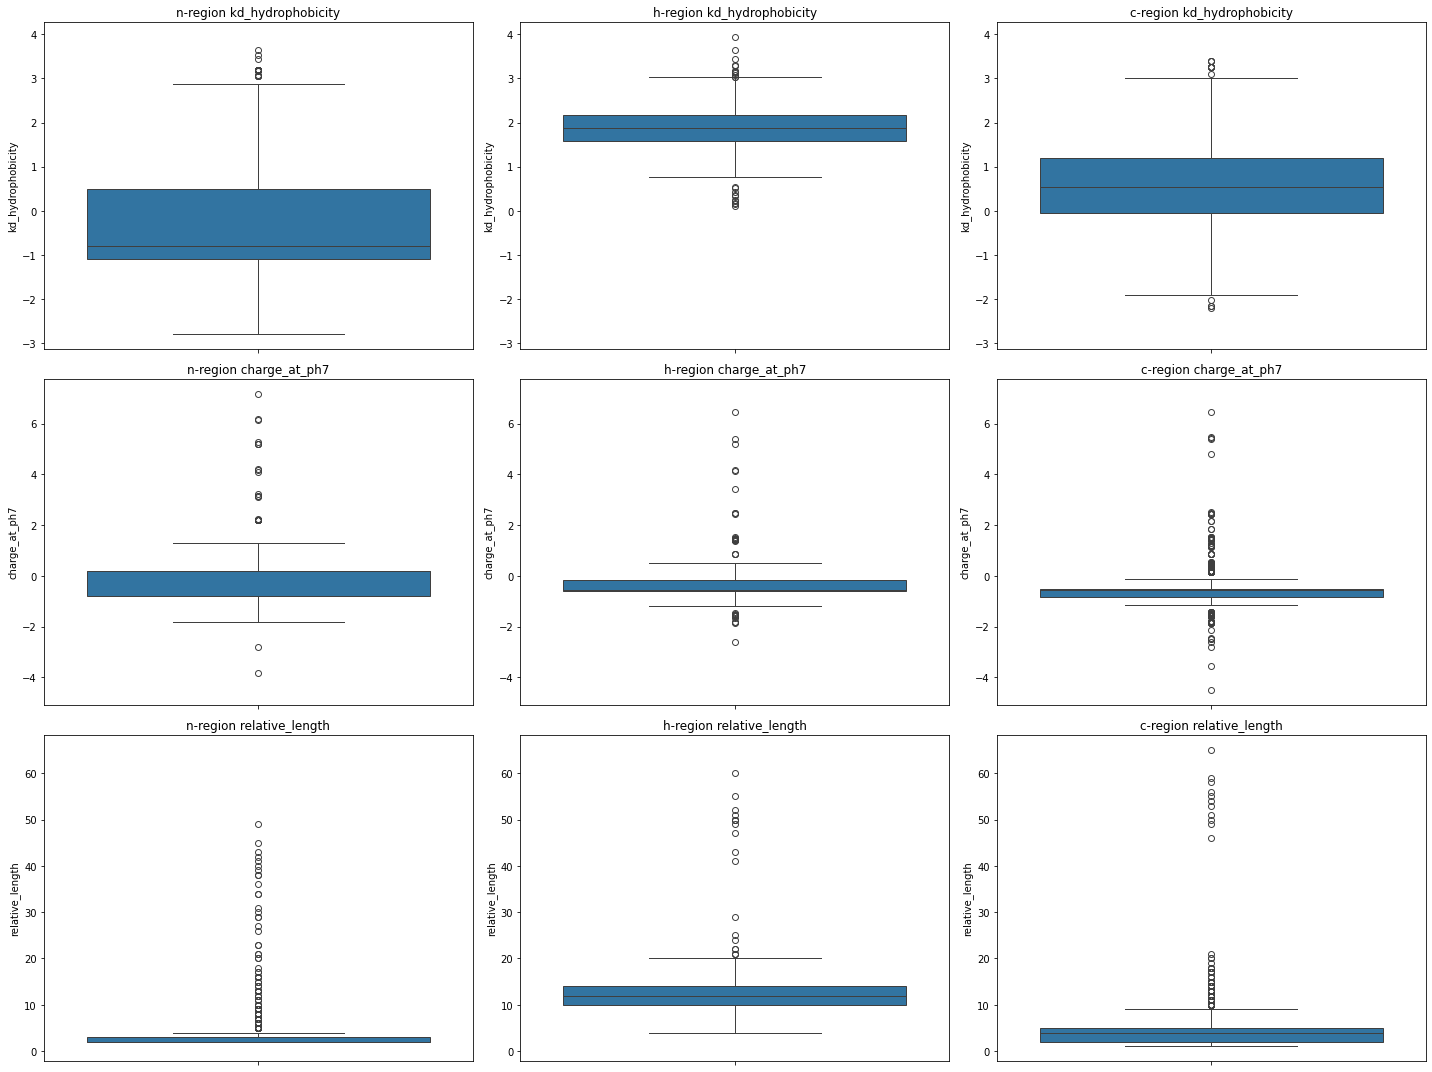

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming n_region, h_region, c_region are your DataFrames

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# First row for 'kd_hydrophobicity'
# n-region
ax1 = plt.subplot(3, 3, 1)
sns.boxplot(y=n_region["kd_hydrophobicity"], orient='vertical')
plt.title('n-region kd_hydrophobicity')

# h-region
ax2 = plt.subplot(3, 3, 2, sharey=ax1)
sns.boxplot(y=h_region["kd_hydrophobicity"], orient='vertical')
plt.title('h-region kd_hydrophobicity')

# c-region
ax3 = plt.subplot(3, 3, 3, sharey=ax1)
sns.boxplot(y=c_region["kd_hydrophobicity"], orient='vertical')
plt.title('c-region kd_hydrophobicity')

# Second row for 'charge_at_ph7'
# n-region
ax4 = plt.subplot(3, 3, 4)
sns.boxplot(y=n_region["charge_at_ph7"], orient='vertical')
plt.title('n-region charge_at_ph7')

# h-region
ax5 = plt.subplot(3, 3, 5, sharey=ax4)
sns.boxplot(y=h_region["charge_at_ph7"], orient='vertical')
plt.title('h-region charge_at_ph7')

# c-region
ax6 = plt.subplot(3, 3, 6, sharey=ax4)
sns.boxplot(y=c_region["charge_at_ph7"], orient='vertical')
plt.title('c-region charge_at_ph7')

# Third row for 'relative_length'
# n-region
ax7 = plt.subplot(3, 3, 7)
sns.boxplot(y=n_region["relative_length"], orient='vertical')
plt.title('n-region relative_length')

# h-region
ax8 = plt.subplot(3, 3, 8, sharey=ax7)
sns.boxplot(y=h_region["relative_length"], orient='vertical')
plt.title('h-region relative_length')

# c-region
ax9 = plt.subplot(3, 3, 9, sharey=ax7)
sns.boxplot(y=c_region["relative_length"], orient='vertical')
plt.title('c-region relative_length')

# Adjust the layout
plt.tight_layout()
plt.show()


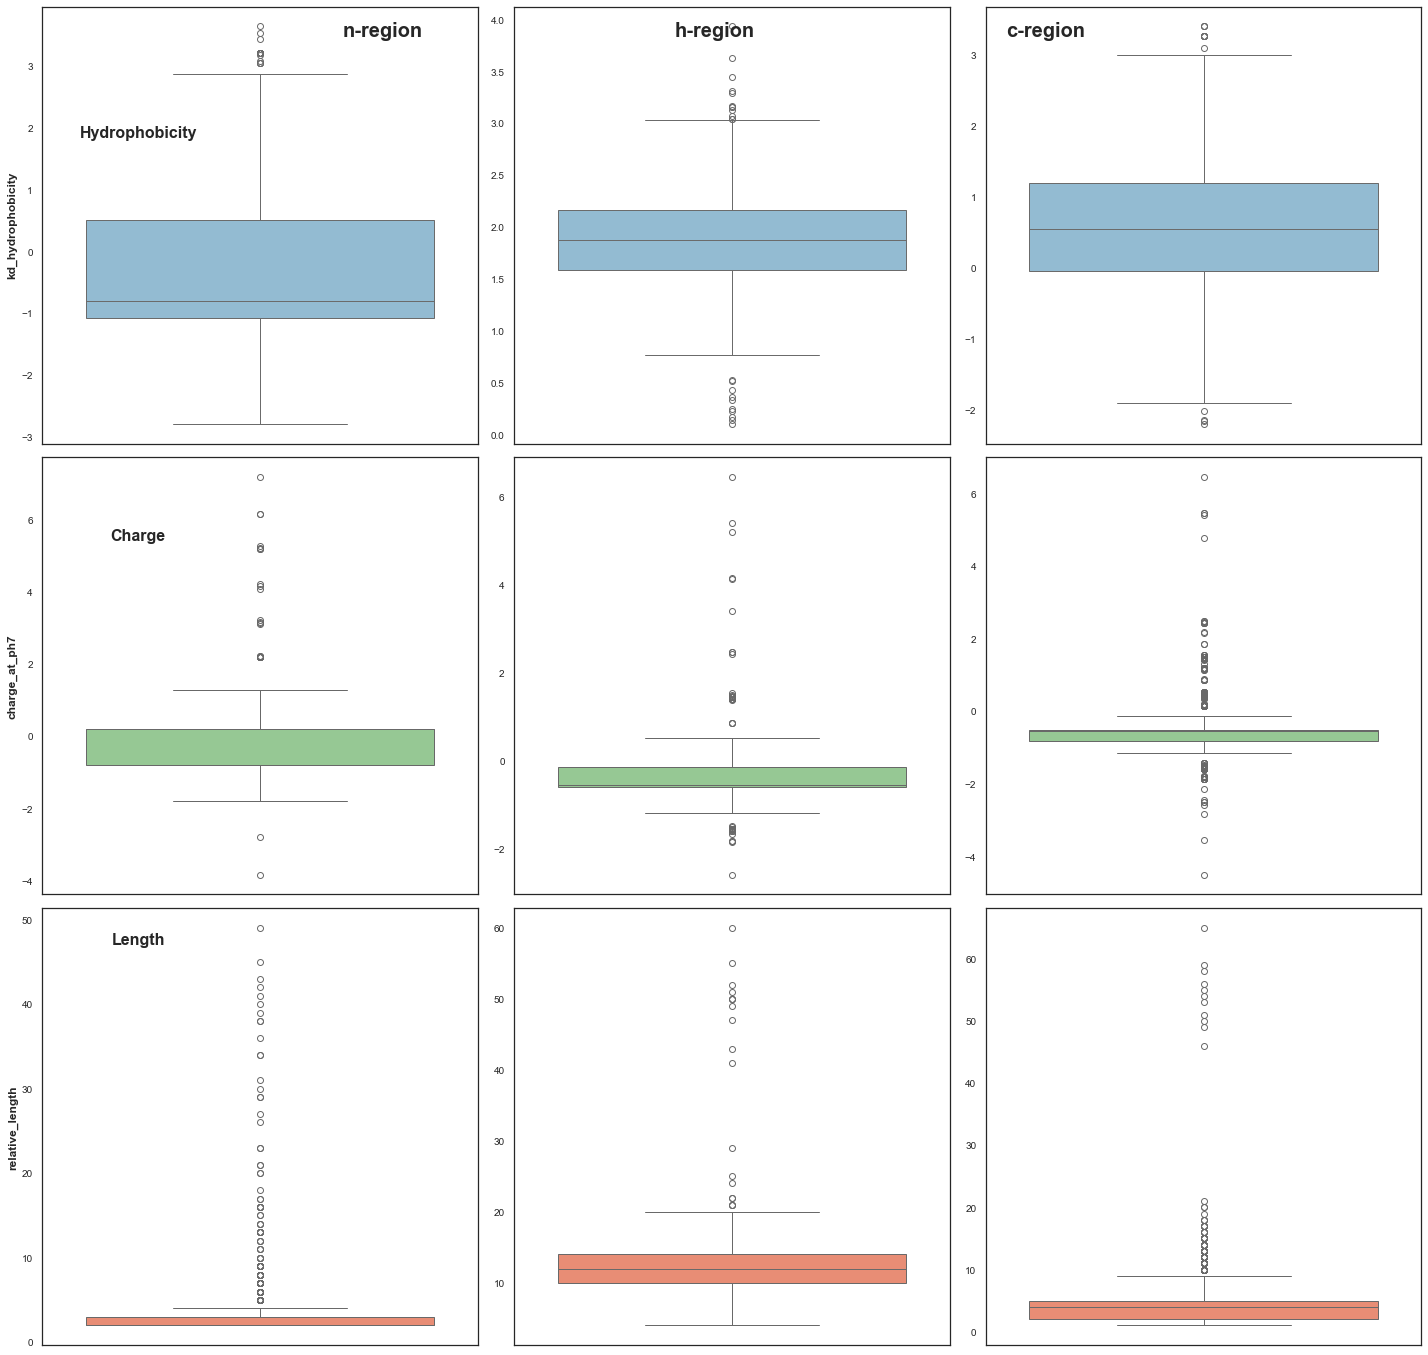

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Set font settings
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"

# Set seaborn style to 'white' or 'ticks' for no grid
sns.set(style='white')

# Custom color palettes for each row
color_palettes = ['Blues', 'Greens', 'Reds']

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Define properties and regions for iteration
properties = ['kd_hydrophobicity', 'charge_at_ph7', 'relative_length']
regions = [n_region, h_region, c_region]
region_names = ['n-region', 'h-region', 'c-region']

# Creating subplots with distinct colors
for i, prop in enumerate(properties):
    palette = sns.color_palette(color_palettes[i])
    for j, region in enumerate(regions):
        ax = plt.subplot(3, 3, i * 3 + j + 1)
        sns.boxplot(y=region[prop], orient='vertical', ax=ax, color=palette[2])  # Using a specific color from the palette
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelsize=10, labelrotation=0)
        
        # Only show y-axis labels for the leftmost plots
        if j == 0:
            ax.set_ylabel(prop, fontsize=12, fontweight='bold')

# Large Vertical Titles for Regions
plt.figtext(0.27, 0.92, 'n-region', ha='center', fontsize=20, fontweight='bold')
plt.figtext(0.5, 0.92, 'h-region', ha='center', fontsize=20, fontweight='bold')
plt.figtext(0.73, 0.92, 'c-region', ha='center', fontsize=20, fontweight='bold')

# Large Horizontal Labels for Properties
plt.figtext(0.1, 0.85, 'Hydrophobicity', ha='center', fontsize=16, fontweight='bold')
plt.figtext(0.1, 0.57, 'Charge', ha='center', fontsize=16, fontweight='bold')
plt.figtext(0.1, 0.29, 'Length', ha='center', fontsize=16, fontweight='bold')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure to a file (optional)
plt.savefig('plot.png', dpi=300, bbox_inches='tight')

plt.show()


## Merging all the biochemistry together

In [34]:
n_region.columns[5:]

Index(['start_pos_region', 'end_pos_region', 'region', 'relative_length',
       'region_seq', 'kd_hydrophobicity', 'charge_at_ph7'],
      dtype='object')

In [35]:
import pandas as pd

# Assuming n_region, h_region, and c_region are your DataFrames

# For n-region
n_region_rename_dict = {col: 'n_' + col for col in n_region.columns[5:]}
n_region = n_region.rename(columns=n_region_rename_dict)

# For h-region
h_region_rename_dict = {col: 'h_' + col for col in h_region.columns[5:]}
h_region = h_region.rename(columns=h_region_rename_dict)

# For c-region
c_region_rename_dict = {col: 'c_' + col for col in c_region.columns[5:]}
c_region = c_region.rename(columns=c_region_rename_dict)


n_region.head()

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,n_start_pos_region,n_end_pos_region,n_region,n_relative_length,n_region_seq,n_kd_hydrophobicity,n_charge_at_ph7
0,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,0,4,n-region,4,MAPS,0.325000,-0.799151
3,AO090005000029-T-p1,0,25,0.99983543,MHLRNIVIALAATAVASPVDLQDRQ,0,2,n-region,2,MH,-0.650000,-0.775725
6,AO090005000042-T-p1,0,25,0.99984324,MKASFISRLLSLTAFAISSNLSYGL,0,2,n-region,2,MK,-1.000000,0.196884
9,AO090005000053-T-p1,0,43,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVALSQ,0,26,n-region,26,MGLFLTALGALSSVNVLYSRGRMPLK,0.684615,2.192839
12,AO090005000059-T-p1,0,20,0.9998212,MHLQATLAVGLSLLGLTLAD,0,2,n-region,2,MH,-0.650000,-0.775725


In [36]:
from functools import reduce

dataframes = [n_region, h_region, c_region]
result = reduce(lambda left, right: pd.merge(left, right, on=['gene','sequence', 'start_pos', 'end_pos', 'signal_peptide_likelyhood']), dataframes)
result

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,n_start_pos_region,n_end_pos_region,n_region,n_relative_length,n_region_seq,...,h_region_seq,h_kd_hydrophobicity,h_charge_at_ph7,c_start_pos_region,c_end_pos_region,c_region,c_relative_length,c_region_seq,c_kd_hydrophobicity,c_charge_at_ph7
0,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,0,4,n-region,4,MAPS,...,HSFMLFLSVICTHLCSL,1.582353,-0.586943,22,24,c-region,2,VVA,3.400000,-0.590986
1,AO090005000029-T-p1,0,25,0.99983543,MHLRNIVIALAATAVASPVDLQDRQ,0,2,n-region,2,MH,...,LRNIVIALAAT,1.590909,0.442738,14,24,c-region,10,AVASPVDLQDR,-0.145455,-1.505143
2,AO090005000042-T-p1,0,25,0.99984324,MKASFISRLLSLTAFAISSNLSYGL,0,2,n-region,2,MK,...,ASFISRLLSLTAFAISSNL,1.184211,0.494293,22,24,c-region,2,SYG,-0.833333,-0.827738
3,AO090005000053-T-p1,0,43,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVALSQ,0,26,n-region,26,MGLFLTALGALSSVNVLYSRGRMPLK,...,HLATLLCALS,1.660000,-0.572083,37,42,c-region,5,PTVALS,1.116667,-0.147963
4,AO090005000059-T-p1,0,20,0.9998212,MHLQATLAVGLSLLGLTLAD,0,2,n-region,2,MH,...,LQATLAVGLSLLGL,1.771429,-0.557223,17,19,c-region,2,TLA,1.633333,-0.857574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,AO090103000483-T-p1,0,21,0.83310604,MKTSFLLAAIGFLYRLPCSAA,0,3,n-region,3,MKT,...,SFLLAAIGFLYRL,1.684615,0.172222,17,20,c-region,3,PCSA,0.475000,-0.186249
1057,AO090103000487-T-p1,0,21,0.99971014,MTRYLSFLFLLILFGNSVFTA,0,3,n-region,3,MTR,...,YLSFLFLLILF,2.709091,-0.561188,15,20,c-region,5,GNSVFT,0.266667,-0.557223
1058,AO090103000493-T-p1,0,19,0.99979144,MRGIVALSFLSVALGVTAD,0,2,n-region,2,MR,...,GIVALSFLSVAL,2.391667,-0.557223,15,18,c-region,3,GVTA,1.225000,-0.557223
1059,AO090701000994-T-p1,0,20,0.99984515,MRLLLIAPLFSAVSYGAQAT,0,2,n-region,2,MR,...,LLLIAPLFSAV,2.536364,-0.557223,14,19,c-region,5,SYGAQA,-0.400000,-0.827738


In [37]:
col_needed = ['gene', 'start_pos', 'end_pos', 'signal_peptide_likelyhood', 'sequence',
       'n_start_pos_region', 'n_end_pos_region',
       'n_relative_length', 'n_region_seq', 'n_kd_hydrophobicity',
       'n_charge_at_ph7', 'h_start_pos_region', 'h_end_pos_region', 
       'h_relative_length', 'h_region_seq', 'h_kd_hydrophobicity',
       'h_charge_at_ph7', 'c_start_pos_region', 'c_end_pos_region', 
       'c_relative_length', 'c_region_seq', 'c_kd_hydrophobicity',
       'c_charge_at_ph7']

final_result = result[col_needed]
final_result

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,n_start_pos_region,n_end_pos_region,n_relative_length,n_region_seq,n_kd_hydrophobicity,...,h_relative_length,h_region_seq,h_kd_hydrophobicity,h_charge_at_ph7,c_start_pos_region,c_end_pos_region,c_relative_length,c_region_seq,c_kd_hydrophobicity,c_charge_at_ph7
0,AO090005000016-T-p1,0,25,0.99980325,MAPSHSFMLFLSVICTHLCSLVVAV,0,4,4,MAPS,0.325000,...,16,HSFMLFLSVICTHLCSL,1.582353,-0.586943,22,24,2,VVA,3.400000,-0.590986
1,AO090005000029-T-p1,0,25,0.99983543,MHLRNIVIALAATAVASPVDLQDRQ,0,2,2,MH,-0.650000,...,10,LRNIVIALAAT,1.590909,0.442738,14,24,10,AVASPVDLQDR,-0.145455,-1.505143
2,AO090005000042-T-p1,0,25,0.99984324,MKASFISRLLSLTAFAISSNLSYGL,0,2,2,MK,-1.000000,...,18,ASFISRLLSLTAFAISSNL,1.184211,0.494293,22,24,2,SYG,-0.833333,-0.827738
3,AO090005000053-T-p1,0,43,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVALSQ,0,26,26,MGLFLTALGALSSVNVLYSRGRMPLK,0.684615,...,9,HLATLLCALS,1.660000,-0.572083,37,42,5,PTVALS,1.116667,-0.147963
4,AO090005000059-T-p1,0,20,0.9998212,MHLQATLAVGLSLLGLTLAD,0,2,2,MH,-0.650000,...,13,LQATLAVGLSLLGL,1.771429,-0.557223,17,19,2,TLA,1.633333,-0.857574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,AO090103000483-T-p1,0,21,0.83310604,MKTSFLLAAIGFLYRLPCSAA,0,3,3,MKT,-0.900000,...,12,SFLLAAIGFLYRL,1.684615,0.172222,17,20,3,PCSA,0.475000,-0.186249
1057,AO090103000487-T-p1,0,21,0.99971014,MTRYLSFLFLLILFGNSVFTA,0,3,3,MTR,-1.100000,...,10,YLSFLFLLILF,2.709091,-0.561188,15,20,5,GNSVFT,0.266667,-0.557223
1058,AO090103000493-T-p1,0,19,0.99979144,MRGIVALSFLSVALGVTAD,0,2,2,MR,-1.300000,...,11,GIVALSFLSVAL,2.391667,-0.557223,15,18,3,GVTA,1.225000,-0.557223
1059,AO090701000994-T-p1,0,20,0.99984515,MRLLLIAPLFSAVSYGAQAT,0,2,2,MR,-1.300000,...,10,LLLIAPLFSAV,2.536364,-0.557223,14,19,5,SYGAQA,-0.400000,-0.827738


In [38]:
col_needed_bioechem = ['gene',
       'n_relative_length', 'n_kd_hydrophobicity',
       'n_charge_at_ph7', 
       'h_relative_length',  'h_kd_hydrophobicity',
       'h_charge_at_ph7', 
       'c_relative_length',  'c_kd_hydrophobicity',
       'c_charge_at_ph7']

biochemical_result = final_result[col_needed_bioechem]
biochemical_result

,gene,n_relative_length,n_kd_hydrophobicity,n_charge_at_ph7,h_relative_length,h_kd_hydrophobicity,h_charge_at_ph7,c_relative_length,c_kd_hydrophobicity,c_charge_at_ph7
0,AO090005000016-T-p1,4,0.325000,-0.799151,16,1.582353,-0.586943,2,3.400000,-0.590986
1,AO090005000029-T-p1,2,-0.650000,-0.775725,10,1.590909,0.442738,10,-0.145455,-1.505143
2,AO090005000042-T-p1,2,-1.000000,0.196884,18,1.184211,0.494293,2,-0.833333,-0.827738
3,AO090005000053-T-p1,26,0.684615,2.192839,9,1.660000,-0.572083,5,1.116667,-0.147963
4,AO090005000059-T-p1,2,-0.650000,-0.775725,13,1.771429,-0.557223,2,1.633333,-0.857574
...,...,...,...,...,...,...,...,...,...,...
1056,AO090103000483-T-p1,3,-0.900000,0.196884,12,1.684615,0.172222,3,0.475000,-0.186249
1057,AO090103000487-T-p1,3,-1.100000,0.200809,10,2.709091,-0.561188,5,0.266667,-0.557223
1058,AO090103000493-T-p1,2,-1.300000,0.200809,11,2.391667,-0.557223,3,1.225000,-0.557223
1059,AO090701000994-T-p1,2,-1.300000,0.200809,10,2.536364,-0.557223,5,-0.400000,-0.827738


## Adding proteomics data

In [39]:
# Load processed signalP dataset
df_proteomics = pd.read_csv('../data/03_proteomics_data/ML_signal_peptides.csv')
df_proteomics

,Accession,sequence,length,abundance,binary_classification
0,AO090003001591-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,1.000000,1
1,AO090003000935-T-p1,MEAFNLHNFLSSLYILLPFVILANPVHAA,29,0.417923,1
2,AO090103000076-T-p1,MLRVSAIFMACLLLATAAPT,20,0.339312,1
3,AO090026000003-T-p1,MAVRIARFLGLSTVAYLALANGIDAR,26,0.276919,1
4,AO090010000746-T-p1,MVSFSSCLRALALGSSVLAVQPVLRQ,26,0.218331,1
...,...,...,...,...,...
1056,AO090026000252-T-p1,MQVKLFYTLALWAPILVSAQ,20,0.000000,0
1057,AO090026000257-T-p1,MKSLIWALPFIPLAYAN,17,0.000000,0
1058,AO090026000367-T-p1,MWPTRSLSSLFFLSLALGSPVSQT,24,0.000000,0
1059,AO090026000428-T-p1,MLLPRLSSLLCLAGLATMPVANAY,24,0.000000,0


In [40]:
# Rename 'Accession' column to 'gene'
df_proteomics.rename(columns={'Accession': 'gene'}, inplace=True)

# Merge with only the 'abundance' column from the new DataFrame
biochemical_result_w_abundance = pd.merge(biochemical_result, df_proteomics[['gene', 'abundance']], on='gene', how='left')
biochemical_result_w_abundance

,gene,n_relative_length,n_kd_hydrophobicity,n_charge_at_ph7,h_relative_length,h_kd_hydrophobicity,h_charge_at_ph7,c_relative_length,c_kd_hydrophobicity,c_charge_at_ph7,abundance
0,AO090005000016-T-p1,4,0.325000,-0.799151,16,1.582353,-0.586943,2,3.400000,-0.590986,0.000000
1,AO090005000029-T-p1,2,-0.650000,-0.775725,10,1.590909,0.442738,10,-0.145455,-1.505143,0.000033
2,AO090005000042-T-p1,2,-1.000000,0.196884,18,1.184211,0.494293,2,-0.833333,-0.827738,0.000048
3,AO090005000053-T-p1,26,0.684615,2.192839,9,1.660000,-0.572083,5,1.116667,-0.147963,0.000000
4,AO090005000059-T-p1,2,-0.650000,-0.775725,13,1.771429,-0.557223,2,1.633333,-0.857574,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1056,AO090103000483-T-p1,3,-0.900000,0.196884,12,1.684615,0.172222,3,0.475000,-0.186249,0.000000
1057,AO090103000487-T-p1,3,-1.100000,0.200809,10,2.709091,-0.561188,5,0.266667,-0.557223,0.000000
1058,AO090103000493-T-p1,2,-1.300000,0.200809,11,2.391667,-0.557223,3,1.225000,-0.557223,0.000000
1059,AO090701000994-T-p1,2,-1.300000,0.200809,10,2.536364,-0.557223,5,-0.400000,-0.827738,0.000000


In [41]:
biochemical_result_w_abundance.to_csv('../data/02_all_signal_peptides/biochemical_result_w_abundance.csv', index=False)